In [1]:
%matplotlib inline
import re
from os import path, getenv, environ
from typing import Dict

from datetime import datetime

import folium
import matplotlib.pyplot as plt
#import missingno as msno
import numpy as np
import pandas as pd
import plotly.express as px
import scipy
import scipy.stats as stats
import seaborn as sns
from sklearn import set_config
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

set_config(display="diagram", print_changed_only=False)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
base_class = pd.read_csv("full_data.csv", sep=",")

<ipython-input-2-a815fba6eee5>:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  base_class = pd.read_csv("full_data.csv", sep=",")


In [3]:
base_class.head()

,entite_eco,personne_morale,annee_soins,colloc,adh_fac,type_cont,genre,code_postal,Age22,type_benef,tranche_age22,Foyer22,rg_benef,PRES2201,PRES2202,PRES2203,PRES2204,PRES2205,PRES2206,PRES2207,PRES2208,PRES2209,PRES2210,PRES2211,PRES2212,ra_0122,ra_0222,ra_0322,ra_0422,ra_0522,ra_0622,ra_0722,ra_0822,ra_0922,ra_1022,ra_1122,ra_1222,fra_0122,fra_0222,fra_0322,fra_0422,fra_0522,fra_0622,fra_0722,fra_0822,fra_0922,fra_1022,fra_1122,fra_1222,PRES2301,PRES2302,PRES2303,PRES2304,PRES2305,PRES2306,PRES2307,PRES2308,PRES2309,PRES2310,PRES2311,PRES2312,ra_0123,ra_0223,ra_0323,ra_0423,ra_0523,ra_0623,ra_0723,ra_0823,ra_0923,ra_1023,ra_1123,ra_1223,fra_0123,fra_0223,fra_0323,fra_0423,fra_0523,fra_0623,fra_0723,fra_0823,fra_0923,fra_1023,fra_1123,fra_1223,PRES2401,PRES2402,PRES2403,PRES2404,PRES2405,PRES2406,PRES2407,PRES2408,PRES2409,PRES2410,PRES2411,PRES2412,ra_0124,ra_0224,ra_0324,ra_0424,ra_0524,ra_0624,ra_0724,ra_0824,fra_0224,fra_0324,fra_0424,fra_0524,fra_0624,fra_0724,fra_0824
0,EE7,PM7,2022.0,non,non,0.0,Femme,13540.0,45.0,Salarié,[45.0; 50.0[,Salarié et conjoint et 2 enfants,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.590000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000,0.0,0.000,0.0,1.68,0.0,0.00,0.0,0.0,0.00,0.000000,0.0,0.00,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EE2703,PM3563,2022.0,non,non,0.0,Enfant,41000.0,10.0,Enfant mineur,[0; 18[,Salarié et conjoint et 2 enfants,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.000000,0.0,0.602857,0.0,0.0,0.000000,0.000000,0.0,0.000,0.0,0.000,0.0,0.00,0.0,1.72,0.0,0.0,0.00,0.000000,0.0,0.00,0.0,0.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EE1979,PM2,2022.0,0,0,0.0,Enfant,99999.0,3.0,Enfant mineur,[0; 18[,Salarié et conjoint et 3+ enfants,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000,0.0,0.000,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.000000,0.0,0.00,0.0,0.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.068571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.445714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,EE2948,PM3908,2022.0,non,non,0.0,Enfant,75018.0,26.0,Enfant majeur,[25.0; 30.0[,Salarié et conjoint et 3+ enfants,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.651667,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000,0.0,0.536,0.0,1.34,0.0,0.00,0.0,0.0,0.00,0.000000,0.0,0.00,0.0,1.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EE2149,PM2680,2022.0,non,non,0.0,Homme,33400.0,32.0,Salarié,[30.0; 35.0[,Salarié et conjoint et 2 enfants,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.523333,1.435714,0.0,6.912,0.0,0.000,0.0,0.00,0.0,0.00,0.0,0.0,1.49,3.325714,0.0,19.74,0.0,0.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
relevant_columns = [
     'ra_0122', 'ra_0222', 'ra_0322', 'ra_0422', 'ra_0522', 'ra_0622', 'ra_0722', 'ra_0822', 'ra_0922', 'ra_1022', 'ra_1122', 'ra_1222',
     'ra_0123', 'ra_0223', 'ra_0323', 'ra_0423', 'ra_0523', 'ra_0623', 'ra_0723', 'ra_0823', 'ra_0923', 'ra_1023', 'ra_1123', 'ra_1223',
     'ra_0124', 'ra_0224', 'ra_0324', 'ra_0424', 'ra_0524', 'ra_0624', 'ra_0724', 'ra_0824' ,
    'genre', 'type_benef', 'Foyer22', "Age22",  "code_postal"
]

In [7]:
base_class_kmeans = base_class[relevant_columns]

In [8]:
base_class_kmeans = pd.get_dummies(base_class_kmeans, columns=['genre', 'type_benef', 'Foyer22'], prefix=['is_genre', 'is_benef', 'is_foyer'])

In [9]:
department_to_region = {
    '75': 'IDF', '77': 'IDF', '78': 'IDF', '91': 'IDF',
    '92': 'IDF', '93': 'IDF', '94': 'IDF', '95': 'IDF',
    '99': 'ETR',
}
default_region = 'OTH'



# Extract department numbers
base_class_kmeans['department'] = base_class_kmeans['code_postal'].astype(str).str[:2]

# Apply the mapping
base_class_kmeans['region'] = base_class_kmeans['department'].map(department_to_region).fillna(default_region)

# One-hot encode regions
base_class_kmeans = pd.get_dummies(base_class_kmeans, columns=['region'], prefix='region')

base_class_kmeans = base_class_kmeans.drop('department', axis=1)

In [10]:
boolean_cols = base_class_kmeans.select_dtypes(include='bool').columns
base_class_kmeans[boolean_cols] = base_class_kmeans[boolean_cols].astype(int)

In [11]:
base_class_kmeans.head()

,ra_0122,ra_0222,ra_0322,ra_0422,ra_0522,ra_0622,ra_0722,ra_0822,ra_0922,ra_1022,ra_1122,ra_1222,ra_0123,ra_0223,ra_0323,ra_0423,ra_0523,ra_0623,ra_0723,ra_0823,ra_0923,ra_1023,ra_1123,ra_1223,ra_0124,ra_0224,ra_0324,ra_0424,ra_0524,ra_0624,ra_0724,ra_0824,Age22,code_postal,is_genre_Enfant,is_genre_Femme,is_genre_Homme,is_genre_Pas de donnees,is_benef_Autre,is_benef_Conjoint,is_benef_Enfant majeur,is_benef_Enfant mineur,is_benef_Salarié,is_foyer_ND,is_foyer_Salarié et 1 enfant,is_foyer_Salarié et 2 enfants,is_foyer_Salarié et 3+ enfants,is_foyer_Salarié et conjoint et 1 enfant,is_foyer_Salarié et conjoint et 2 enfants,is_foyer_Salarié et conjoint et 3+ enfants,is_foyer_Salarié et conjoint sans enfant,is_foyer_Salarié seul,region_ETR,region_IDF,region_OTH
0,0.0,0.590000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000,0.0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,13540.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
1,0.0,0.000000,0.0,0.602857,0.0,0.0,0.000000,0.000000,0.0,0.000,0.0,0.000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,41000.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
2,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000,0.0,0.000,0.0,1.068571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,99999.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
3,0.0,0.651667,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000,0.0,0.536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,75018.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0.0,0.000000,0.0,0.000000,0.0,0.0,0.523333,1.435714,0.0,6.912,0.0,0.000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,33400.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


In [17]:
base_class_kmeans = base_class_kmeans.drop('code_postal', axis=1)
base_class_kmeans = base_class_kmeans.fillna(0)

In [18]:
scaler = StandardScaler()

base_class_scaled = scaler.fit_transform(base_class_kmeans)
base_class_scaled = pd.DataFrame(base_class_scaled, columns=base_class_kmeans.columns)

In [19]:
base_class_scaled.head()

,ra_0122,ra_0222,ra_0322,ra_0422,ra_0522,ra_0622,ra_0722,ra_0822,ra_0922,ra_1022,ra_1122,ra_1222,ra_0123,ra_0223,ra_0323,ra_0423,ra_0523,ra_0623,ra_0723,ra_0823,ra_0923,ra_1023,ra_1123,ra_1223,ra_0124,ra_0224,ra_0324,ra_0424,ra_0524,ra_0624,ra_0724,ra_0824,Age22,is_genre_Enfant,is_genre_Femme,is_genre_Homme,is_genre_Pas de donnees,is_benef_Autre,is_benef_Conjoint,is_benef_Enfant majeur,is_benef_Enfant mineur,is_benef_Salarié,is_foyer_ND,is_foyer_Salarié et 1 enfant,is_foyer_Salarié et 2 enfants,is_foyer_Salarié et 3+ enfants,is_foyer_Salarié et conjoint et 1 enfant,is_foyer_Salarié et conjoint et 2 enfants,is_foyer_Salarié et conjoint et 3+ enfants,is_foyer_Salarié et conjoint sans enfant,is_foyer_Salarié seul,region_ETR,region_IDF,region_OTH
0,-0.05322,0.073410,-0.05886,-0.049240,-0.050051,-0.058417,-0.046082,-0.046065,-0.051792,-0.052139,-0.053888,-0.051983,-0.049586,-0.050619,-0.049392,-0.053213,-0.060782,-0.056046,-0.055844,-0.052109,-0.058159,-0.053342,-0.049871,-0.045486,-0.047566,-0.043857,-0.047649,-0.046702,-0.044938,-0.045565,-0.046817,-0.043816,0.001348,-0.662308,1.402071,-0.746600,-0.003138,-0.025324,-0.413558,-0.224404,-0.588069,0.907455,-0.124873,-0.233163,-0.23278,-0.174211,-0.316068,2.022929,-0.486418,-0.272784,-0.661573,-0.623298,-0.466494,0.920216
1,-0.05322,-0.047635,-0.05886,0.079363,-0.050051,-0.058417,-0.046082,-0.046065,-0.051792,-0.052139,-0.053888,-0.051983,-0.049586,-0.050619,-0.049392,-0.053213,-0.060782,-0.056046,-0.055844,-0.052109,-0.058159,-0.053342,-0.049871,-0.045486,-0.047566,-0.043857,-0.047649,-0.046702,-0.044938,-0.045565,-0.046817,-0.043816,-0.312354,1.509872,-0.713231,-0.746600,-0.003138,-0.025324,-0.413558,-0.224404,1.700479,-1.101983,-0.124873,-0.233163,-0.23278,-0.174211,-0.316068,2.022929,-0.486418,-0.272784,-0.661573,-0.623298,-0.466494,0.920216
2,-0.05322,-0.047635,-0.05886,-0.049240,-0.050051,-0.058417,-0.046082,-0.046065,-0.051792,-0.052139,-0.053888,-0.051983,-0.049586,0.243133,-0.049392,-0.053213,-0.060782,-0.056046,-0.055844,-0.052109,-0.058159,-0.053342,-0.049871,-0.045486,-0.047566,-0.043857,-0.047649,-0.046702,-0.044938,-0.045565,-0.046817,-0.043816,-0.375094,1.509872,-0.713231,-0.746600,-0.003138,-0.025324,-0.413558,-0.224404,1.700479,-1.101983,-0.124873,-0.233163,-0.23278,-0.174211,-0.316068,-0.494333,2.055845,-0.272784,-0.661573,1.604369,-0.466494,-1.086701
3,-0.05322,0.086061,-0.05886,-0.049240,-0.050051,-0.058417,-0.046082,-0.046065,-0.051792,-0.052139,-0.053888,0.050634,-0.049586,-0.050619,-0.049392,-0.053213,-0.060782,-0.056046,-0.055844,-0.052109,-0.058159,-0.053342,-0.049871,-0.045486,-0.047566,-0.043857,-0.047649,-0.046702,-0.044938,-0.045565,-0.046817,-0.043816,-0.168947,1.509872,-0.713231,-0.746600,-0.003138,-0.025324,-0.413558,4.456246,-0.588069,-1.101983,-0.124873,-0.233163,-0.23278,-0.174211,-0.316068,-0.494333,2.055845,-0.272784,-0.661573,-0.623298,2.143650,-1.086701
4,-0.05322,-0.047635,-0.05886,-0.049240,-0.050051,-0.058417,0.068985,0.297467,-0.051792,1.366459,-0.053888,-0.051983,-0.049586,-0.050619,-0.049392,-0.053213,-0.060782,-0.056046,-0.055844,-0.052109,-0.058159,-0.053342,-0.049871,-0.045486,-0.047566,-0.043857,-0.047649,-0.046702,-0.044938,-0.045565,-0.046817,-0.043816,-0.115170,-0.662308,-0.713231,1.339406,-0.003138,-0.025324,-0.413558,-0.224404,-0.588069,0.907455,-0.124873,-0.233163,-0.23278,-0.174211,-0.316068,2.022929,-0.486418,-0.272784,-0.661573,-0.623298,-0.466494,0.920216


In [20]:
# Removing outliers
from scipy.stats import zscore
base_class_array = base_class_kmeans.values

base_class_array = base_class_array.astype(np.float32)
z_scores = np.abs(zscore(base_class_array))
outliers = np.where(z_scores > 3)

print("Outliers:", outliers, len(outliers))


base_class_array_cleaned = base_class_array[(z_scores < 3).all(axis=1)]


Outliers: (array([      3,       5,       7, ..., 1015762, 1015764, 1015768]), array([39, 49, 49, ..., 46, 39, 43])) 2


In [21]:
def initialize_centroids(base_class, k):

    centroids = base_class[np.random.choice(base_class.shape[0], k, replace=False)]
    return centroids

In [22]:
def assign_clusters(base_class, centroids):

    distances = np.linalg.norm(base_class[:, np.newaxis] - centroids, axis=2)

    cluster_labels = np.argmin(distances, axis=1)
    return cluster_labels

In [23]:
def update_centroids(base_class, cluster_labels, k):
    new_centroids = np.array([base_class[cluster_labels == i].mean(axis=0) for i in range(k)])
    return new_centroids

In [24]:
def kmeans(base_class, k, max_iters=100, tol=1e-4):

    # Initialisation des centroids

    centroids = initialize_centroids(base_class, k)

    for _ in range(max_iters):
        # On attribu à chaque point un cluster
        cluster_labels = assign_clusters(base_class, centroids)

        # On calcule les nouveaux centroids
        new_centroids = update_centroids(base_class, cluster_labels, k)

        # On vérifie la convergence
        if np.all(np.abs(new_centroids - centroids) < tol):
            break

        centroids = new_centroids
            # Calculate WCSS (sum of squared distances to closest centroid)
        wcss = np.sum(
          np.min(np.linalg.norm(base_class[:, np.newaxis] - centroids, axis=2) ** 2, axis=1)
        )
    return cluster_labels, centroids, wcss

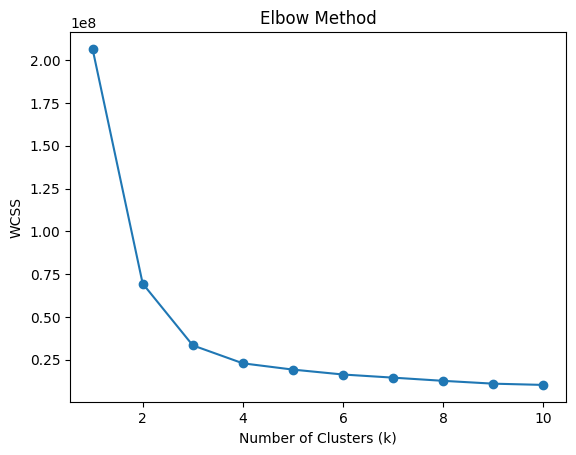

In [27]:
# Elbow method to determine optimal k


wcss = []
for k in range(1, 11):
    _, _, current_wcss = kmeans(base_class_array_cleaned, k)
    wcss.append(current_wcss)

plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

# Pick k = 3

k = 3

In [25]:
cluster_labels, final_centroids, _ = kmeans(base_class_array_cleaned, k = 3)

print("Cluster Labels:", cluster_labels)
print("Final Centroids:", final_centroids)

Cluster Labels: [2 0 0 ... 1 0 0]
Final Centroids: [[1.52673289e-01 1.19729206e-01 1.34723306e-01 1.40210405e-01
  1.38559043e-01 1.32451668e-01 1.24629393e-01 1.01884477e-01
  1.66577548e-01 1.63962707e-01 1.57895967e-01 1.63237259e-01
  1.05906457e-01 9.82665196e-02 1.11545034e-01 8.98989066e-02
  8.50697756e-02 9.81237292e-02 7.68136010e-02 6.68075383e-02
  8.99349526e-02 9.19808298e-02 9.09786671e-02 8.98823589e-02
  6.77994192e-02 6.43219128e-02 6.02979548e-02 5.18510416e-02
  4.83376607e-02 5.42757139e-02 4.66710404e-02 3.90850008e-02
  9.17767620e+00 9.58638072e-01 2.15710290e-02 1.97909232e-02
  0.00000000e+00 0.00000000e+00 5.66912699e-04 0.00000000e+00
  9.58638072e-01 4.07950394e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 4.30156350e-01
  5.29400110e-01 0.00000000e+00 4.04435508e-02 2.94862628e-01
  1.73129469e-01 5.32007873e-01]
 [1.19417422e-01 1.10999629e-01 1.27547309e-01 1.20947517e-01
  1.26307458e-01 1.24504372e-01 1.12375051e-01 9

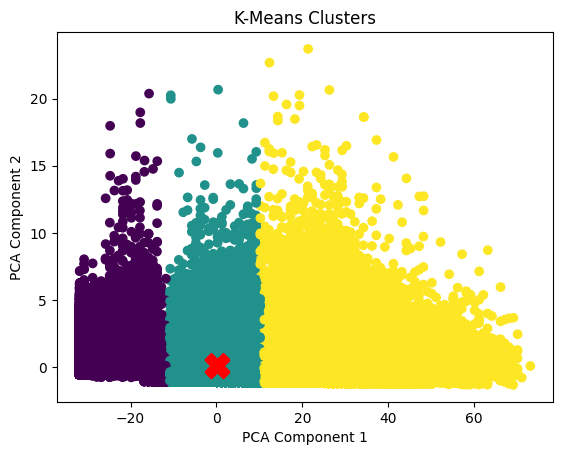

In [26]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


pca = PCA(n_components=2)
base_class_pca = pca.fit_transform(base_class_array_cleaned)


plt.scatter(base_class_pca[:, 0], base_class_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.scatter(final_centroids[:, 0], final_centroids[:, 1], s=300, c='red', marker='X')  # Centroids
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clusters')
plt.show()


In [ ]:
# Save the original column names
original_column_names = base_class_kmeans.columns.tolist()

# Create the DataFrame with proper column names
clustered_data = pd.DataFrame(base_class_array_cleaned, columns=original_column_names)

# Add the cluster labels
clustered_data['Cluster'] = cluster_labels

# Group by Cluster and calculate the mean
print(clustered_data.groupby('Cluster').mean())

            ra_01     ra_02     ra_03     ra_04     ra_05     ra_06     ra_07  \
Cluster                                                                         
0        0.262044  0.249982  0.274513  0.261212  0.261287  0.262272  0.248127   
1        0.190343  0.150283  0.188124  0.175427  0.174361  0.189329  0.157338   
2        0.158149  0.146488  0.169967  0.160725  0.168357  0.165959  0.149690   

            ra_08     ra_09     ra_10     ra_11     ra_12      Age22  \
Cluster                                                                
0        0.214316  0.253072  0.259845  0.262881  0.270781  51.967403   
1        0.150452  0.215441  0.210457  0.204334  0.210459   9.087377   
2        0.134341  0.158463  0.164052  0.162423  0.176584  31.714567   

         pp_mens_act  is_genre_Enfant  is_genre_Femme  is_genre_Homme  \
Cluster                                                                 
0           0.256695         0.000000        0.544563        0.455437   
1           0.

In [ ]:
cluster_0 = pd.DataFrame(clustered_data[clustered_data['Cluster'] == 0])
cluster_1 = pd.DataFrame(clustered_data[clustered_data['Cluster'] == 1])
cluster_2 = pd.DataFrame(clustered_data[clustered_data['Cluster'] == 2])

In [ ]:
cluster_0.head()

,ra_01,ra_02,ra_03,ra_04,ra_05,ra_06,ra_07,ra_08,ra_09,ra_10,ra_11,ra_12,Age22,pp_mens_act,is_genre_Enfant,is_genre_Femme,is_genre_Homme,is_benef_Conjoint,is_benef_Enfant majeur,is_benef_Enfant mineur,is_benef_Salarie,is_foyer_ND,is_foyer_Salarie et 1 enfant,is_foyer_Salarie et 2 enfants,is_foyer_Salarie et 3+ enfants,is_foyer_Salarie et conjoint et 1 enfant,is_foyer_Salarie et conjoint et 2 enfants,is_foyer_Salarie et conjoint et 3+ enfants,is_foyer_Salarie et conjoint sans enfant,is_foyer_Salarie seul,region_ETR,region_IDF,region_OTH,Cluster
0,0.000000,0.59,0.000,0.0,0.0,0.00,0.000000,0.000,0.000000,0.0000,0.000000,0.0,45.0,0.049167,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
8,0.967500,0.00,0.000,0.0,0.0,1.34,0.665714,0.000,0.000000,0.6115,0.000000,0.0,72.0,0.298726,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
10,0.000000,0.00,1.185,0.0,0.0,0.00,0.000000,0.000,0.000000,0.0000,0.000000,0.0,55.0,0.098750,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
13,0.763333,0.00,0.000,0.0,0.0,0.71,0.000000,0.710,0.893333,0.0000,0.000000,0.0,54.0,0.256389,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
17,1.396667,0.00,0.000,0.0,0.0,0.00,0.000000,3.972,0.000000,3.6800,3.441667,0.0,62.0,1.040861,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
